In [53]:
!pip install asyncpraw pandas vaderSentiment fredapi yfinance matplotlib scikit-learn tensorflow

In [54]:
import datetime
import asyncpraw as praw
import pandas as pd
import requests

from google.colab import userdata
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from fredapi import Fred
import yfinance as yf
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Bidirectional,
    LSTM,
    Dropout,
    Dense,
    Attention,
    Flatten,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

sia = SentimentIntensityAnalyzer()

"""
Model details:
1. Will use the VADER sentiment analysis model to analyze the sentiment of the top 10 posts on the subreddit r/wallstreetbets
2. Will use the FRED API to get the latest data on the 10-year treasury yield
3. Will use the yfinance API to get the latest data on the S&P 500 index
4. Will use the scikit-learn library to scale the data
5. Will use the tensorflow library to create a simple neural network model using CNN and LSTM layers
    X = all columns of the dataset except (12 weeks)
    y = the 13th week's closing price
6. Will use the matplotlib library to plot the results
"""

"\nModel details:\n1. Will use the VADER sentiment analysis model to analyze the sentiment of the top 10 posts on the subreddit r/wallstreetbets\n2. Will use the FRED API to get the latest data on the 10-year treasury yield\n3. Will use the yfinance API to get the latest data on the S&P 500 index\n4. Will use the scikit-learn library to scale the data\n5. Will use the tensorflow library to create a simple neural network model using CNN and LSTM layers\n    X = all columns of the dataset except (12 weeks)\n    y = the 13th week's closing price\n6. Will use the matplotlib library to plot the results\n"

# Config

In [55]:
now = datetime.datetime.now()

START = datetime.datetime(2019, 5, 1)
END = datetime.datetime(now.year, now.month, 1)
PERIOD = "1d"
SEN_WEIGHT = 0.5
INPUT_LENGTH = 12 # 12 weeks of data
OUTPUT_LENGTH = 1 # 1 week of data
STOCK = "AAPL"
SPLIT_RATIO = 0.8 # 80% train, 20% validation
ALPHA_KEY = userdata.get('APLHA_KEY')
FRED_API_KEY = userdata.get('FRED_KEY')

reddit = praw.Reddit(
    client_id=userdata.get('REDDIT_CLIENT_ID'),
    client_secret=userdata.get('REDDIT_CLIENT_SECRET'),
    user_agent="Bob",
)

fred = Fred(FRED_API_KEY)

# Sentiment Data

In [56]:
def toUnixTimeStamp(conv: datetime.datetime):
    return int(datetime.datetime.timestamp(conv))


async def getSenData(stock, start=START - datetime.timedelta(weeks=2), end=END):
    subs = {"date": [], "title": [], "weight": []}

    async def search_subreddit(subreddit, query, start, end):
        async for submission in subreddit.search(
            query, sort="age", limit=100000000000000000000000000000
        ):
            # Check if submission falls within the date range
            # print(submission.upvote_ratio)
            if start <= int(submission.created_utc):
                subs["date"].append(datetime.datetime.utcfromtimestamp(submission.created_utc))
                subs["title"].append(submission.title)
                subs["weight"].append(submission.upvote_ratio)

    async def search_batch(subreddits, queries, start, end):
        for sub in subreddits:
            for query in queries:
                await search_subreddit(await reddit.subreddit(sub), query, start, end)

    subreddits = ["wallstreetbets", "stocks", "news", "Economics"]

    start_ust = toUnixTimeStamp(start)
    end_ust = toUnixTimeStamp(end)

    await search_batch(subreddits, [stock["Symbol"], stock["Name"]], start_ust, end_ust)

    # remove duplicates
    subs = pd.DataFrame(subs)
    subs = subs.drop_duplicates(subset=["title"])

    subs["sentiment"] = [
        sia.polarity_scores(title)["compound"] for title in subs["title"]
    ]

    return pd.DataFrame(subs)

# Economic Data - Fed & Stock

In [57]:
def getCompanyData(ticker: str):
    return requests.get(
        f"https://www.alphavantage.co/query?function=OVERVIEW&symbol={ticker}&apikey={ALPHA_KEY}"
    ).json()


def get_fred_data(start_date=START, end_date=END):
    """
    Fetches macroeconomic indicators from FRED and returns them as a DataFrame.
    """
    # Define the macroeconomic indicators
    indicators = {
        "Federal Funds Rate": "FEDFUNDS",
        "CPI": "CPIAUCSL",
        "Unemployment Rate": "UNRATE",
        "GDP Growth Rate": "A191RL1Q225SBEA",
        "10-Year Treasury Rate": "GS10",
        "S&P 500": "SP500",
        "US Dollar Index": "RTWEXBGS",
        "Industrial Production Index": "INDPRO",
        "Consumer Sentiment": "UMCSENT",
        "Housing Starts": "HOUST",
    }

    # Initialize a dictionary to store the data
    fred_data = {}

    # Fetch data for each indicator
    for indicator, code in indicators.items():
        indicator_data = fred.get_series(code, start_date, end_date)

        # Convert to DataFrame with proper index
        indicator_data = pd.DataFrame(indicator_data)
        indicator_data.columns = [indicator]  # Rename the column to the indicator name

        # Ensure the index is a DatetimeIndex
        indicator_data.index = pd.to_datetime(indicator_data.index)

        # Resample to daily data and forward fill missing values
        indicator_data = indicator_data.resample("D").ffill()

        # Add the indicator data to the dictionary
        fred_data[indicator] = indicator_data[indicator]

    # Convert the dictionary into a DataFrame
    fred_df = pd.DataFrame(fred_data)

    fred_df.index = fred_df.index.get_level_values(0)

    return fred_df


def get_stock_data(ticker, fred_data, sen_data, start_date=START, end_date=END):
    """
    Fetches stock data using yfinance, calculates technical indicators,
    and adds macroeconomic data fetched from FRED.
    """
    # Get stock data using yfinance
    stock_data = yf.download(
        ticker,
        start=start_date - datetime.timedelta(days=200),
        end=end_date,
        interval=PERIOD,
    )
    stock_data.index = pd.to_datetime(stock_data.index)

    # Add technical indicators (e.g., Moving Averages)
    stock_data["MA_50"] = stock_data["Close"].rolling(window=50).mean()
    stock_data["MA_200"] = stock_data["Close"].rolling(window=200).mean()

    # Add Returns (percentage change)
    stock_data["Returns"] = stock_data["Close"].pct_change()

    # Add RSI (Relative Strength Index)
    delta = stock_data["Close"].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    stock_data["RSI"] = 100 - (100 / (1 + rs))

    stock_data.drop(stock_data.index[:200], inplace=True)

    # Add MACD (Moving Average Convergence Divergence)
    stock_data["EMA_12"] = stock_data["Close"].ewm(span=12, adjust=False).mean()
    stock_data["EMA_26"] = stock_data["Close"].ewm(span=26, adjust=False).mean()
    stock_data["MACD"] = stock_data["EMA_12"] - stock_data["EMA_26"]

    stock_data.columns = stock_data.columns.get_level_values(0)
    stock_data.index = stock_data.index.tz_localize(None)
    fred_data.index = fred_data.index.tz_localize(None)

    # Merge FRED data with stock data
    stock_data = stock_data.join(fred_data, how="left")

    # Handle missing data by forward filling
    stock_data.ffill(inplace=True)

    stock_data = stock_data.resample("W").mean()

    stock_data.index = pd.to_datetime(stock_data.index).tz_localize("UTC")

    sen_data["date"] = sen_data["date"].dt.tz_localize("UTC")

    print(sen_data["date"][0], type(sen_data["date"][0]))
    print(stock_data.index[0], type(stock_data.index[0]))

    # for each date in the stock data, find the all the dates between the last date and the current date in the sentiment data. Average the sentiment weights for those dates and add it to the stock data. For the first date, use all the sentiment data before that date.
    for i in range(len(stock_data)):
        if i == 0:
            stock_data.loc[stock_data.index[i], "Sentiment"] = sen_data[
                sen_data["date"] < stock_data.index[i]
            ]["weight"].mean()
        else:
            stock_data.loc[stock_data.index[i], "Sentiment"] = sen_data[
                (sen_data["date"] < stock_data.index[i])
                & (sen_data["date"] >= stock_data.index[i - 1])
            ]["weight"].mean()

    stock_data["Sentiment"] = stock_data["Sentiment"].ffill()

    return stock_data

# Get Data

In [58]:
# comp = getCompanyData(STOCK)
comp = {"Symbol": "AAPL", "Name": "Apple Inc."}
sen = await getSenData(comp)

In [59]:
data = get_stock_data(STOCK, get_fred_data(), sen)

[*********************100%***********************]  1 of 1 completed


2024-08-29 16:48:03+00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2019-08-04 00:00:00+00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>


<Axes: >

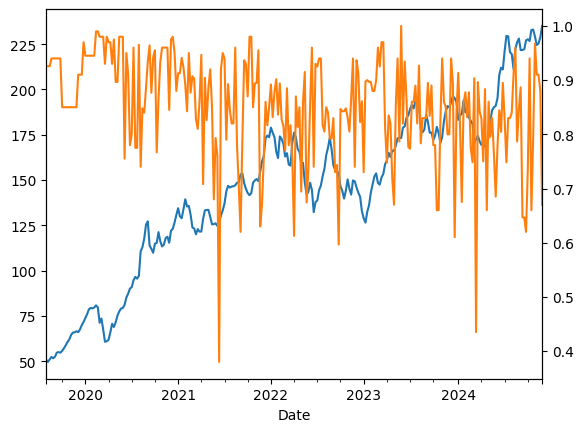

In [60]:
# graph data sentiment and stock price relative to each other
data["Close"].plot()
data["Sentiment"].plot(secondary_y=True)

# Preprocessing

In [61]:
data.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'MA_50',
       'MA_200', 'Returns', 'RSI', 'EMA_12', 'EMA_26', 'MACD',
       'Federal Funds Rate', 'CPI', 'Unemployment Rate', 'GDP Growth Rate',
       '10-Year Treasury Rate', 'S&P 500', 'US Dollar Index',
       'Industrial Production Index', 'Consumer Sentiment', 'Housing Starts',
       'Sentiment'],
      dtype='object')

In [62]:
"""
Preprocessing the data (recorded for future reference)
1. Normalize the data

To preserve the reelationship between the Stock and Technical Indicators ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'MA_50', 'MA_200', 'Returns', 'RSI', 'EMA_12', 'EMA_26', 'MACD'], a single MinMaxScaler is used to normalize the data.

Macroeconomic Data ['Federal Funds Rate', 'CPI', 'Unemployment Rate', 'GDP Growth Rate', '10-Year Treasury Rate', 'S&P 500', 'US Dollar Index', 'Industrial Production Index', 'Consumer Sentiment', 'Housing Starts'] will be normalized using a StandardScaler because many macroeconomic variables can have large variance, and scaling them to zero mean and unit variance will help models interpret them better.

Sentiment column will not be normalized because it is already between -1 and 1 (may scale between 0 and 1 later for consistency?).

2. Split the data into input and output data

A sliding window approach will be used to create the input and output data. The input data will be the past 12 weeks of data, and the output data will be the next week of data. This will be done for each row in the data. (can use a different window size later)

3. Split the data into training and testing data

The data will be split into training and testing data using an 80/20 split. The first 80% of the data will be used for training, and the last 20% will be used for testing. (can use a different split ratio later)

4. Create a function to turn preprocessed data (both X and y data) into human readable data

"""


preprocessed_data = data.copy()

# Normalize the data
stock_tech_scaler = MinMaxScaler()
macro_scaler = StandardScaler()

stock_tech_cols = [
    "Adj Close",
    "Close",
    "High",
    "Low",
    "Open",
    "Volume",
    "MA_50",
    "MA_200",
    "Returns",
    "RSI",
    "EMA_12",
    "EMA_26",
    "MACD",
]

preprocessed_data[stock_tech_cols] = stock_tech_scaler.fit_transform(
    preprocessed_data[stock_tech_cols]
)

macro_cols = [
    "Federal Funds Rate",
    "CPI",
    "Unemployment Rate",
    "GDP Growth Rate",
    "10-Year Treasury Rate",
    "S&P 500",
    "US Dollar Index",
    "Industrial Production Index",
    "Consumer Sentiment",
    "Housing Starts",
]

preprocessed_data[macro_cols] = macro_scaler.fit_transform(
    preprocessed_data[macro_cols]
)


# Split the data into input and output data. Will also remove all columns for the output data except the closing price for the 13th week.
def create_input_output(data, input_length=INPUT_LENGTH, output_length=OUTPUT_LENGTH):
    X = []
    y = []

    for i in range(len(data) - input_length - output_length + 1):
        X.append(data.iloc[i : i + input_length].values)
        y.append(
            data.iloc[i + input_length : i + input_length + output_length][
                "Close"
            ].values
        )

    return np.array(X), np.array(y)


# Split the data into training and testing data
def split_data(X, y, split_ratio=SPLIT_RATIO):
    split_index = int(len(X) * split_ratio)

    X_train, y_train = X[:split_index], y[:split_index]
    X_val, y_val = X[split_index:], y[split_index:]

    return X_train, y_train, X_val, y_val


X_train, y_train, X_val, y_val = split_data(*create_input_output(preprocessed_data))

n_timesteps = INPUT_LENGTH  # 12 weeks of input data
n_features = len(stock_tech_cols) + len(macro_cols) + 1  # Adding 1 for the sentiment column

In [63]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(213, 12, 24) (213, 1) (54, 12, 24) (54, 1)


# Model

In [64]:
# Define input shape
input_layer = Input(shape=(n_timesteps, n_features))

# CNN Block
x = Conv1D(
    filters=128,
    kernel_size=3,
    activation="relu",
    padding="same",
)(input_layer)
x = Conv1D(filters=128, kernel_size=5, activation="relu", padding="same")(x)
x = Conv1D(filters=64, kernel_size=7, activation="relu", padding="same")(x)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)

# LSTM Block
x = Bidirectional(LSTM(units=256, return_sequences=True))(x)
x = Dropout(0.3)(x)
x = LSTM(units=128, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(units=64, return_sequences=True)(x)
x = Dropout(0.3)(x)

# Attention Mechanism
query = Dense(64)(x)  # Learnable query
attention = Attention()([query, x])
attention_output = Flatten()(attention)

# Dense Block
x = Dense(units=128, activation="relu")(attention_output)
x = Dropout(0.3)(x)
x = Dense(units=64, activation="relu")(x)
x = Dense(units=32, activation="relu")(x)

# Output Layer
output_layer = Dense(units=1, activation="linear")(x)

# Define model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(), loss=Huber())

# Display model summary
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 12, 24)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 12, 128)        │          9,344 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 12, 128)        │         82,048 │ conv1d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 12, 64)         │         57,408 │ conv1d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 6, 64)          │              0 │ conv1d_14[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 6, 64)          │            256 │ max_pooling1d_4[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 6, 512)         │        657,408 │ batch_normalization_4… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 6, 512)         │              0 │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_13 (LSTM)            │ (None, 6, 128)         │        328,192 │ dropout_15[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 6, 128)         │              0 │ lstm_13[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_14 (LSTM)            │ (None, 6, 64)          │         49,408 │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 6, 64)          │              0 │ lstm_14[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 6, 64)          │          4,160 │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_4 (Attention)   │ (None, 6, 64)          │              0 │ dense_15[0][0],        │
│                           │                        │                │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 384)            │              0 │ attention_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 128)            │         49,280 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 128)            │              0 │ dense_16[0][0]         │
├──────────────────────

 Total params: 1,247,873 (4.76 MB)

 Trainable params: 1,247,745 (4.76 MB)

 Non-trainable params: 128 (512.00 B)

# Training

Epoch 1/100


ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7ea73377b430>


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - loss: 0.0761 - val_loss: 0.1391
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0080 - val_loss: 0.0341
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0079 - val_loss: 0.0870
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0046 - val_loss: 0.0522
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0037 - val_loss: 0.0250
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0028 - val_loss: 0.0255
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 0.0034 - val_loss: 0.0179
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.0032 - val_loss: 0.0160
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0035 - val_loss: 0.0282
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0029 - val_loss: 0.0136
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0026 - val_loss: 0.0083
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0032 - val_loss:

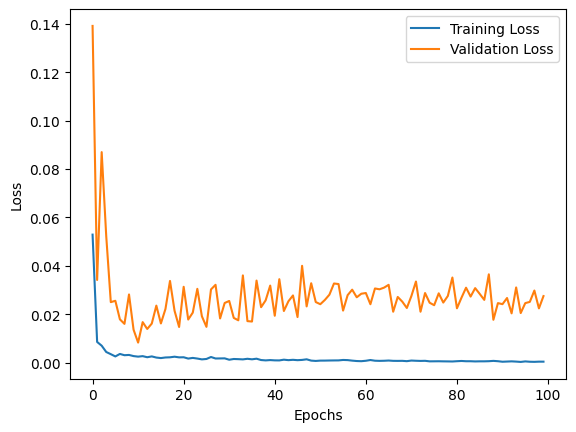

In [65]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Adjust as needed
    batch_size=32,  # Adjust as needed
    # callbacks=[early_stopping, checkpoint]
    callbacks=[checkpoint]
)

# Evaluate the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()